## Importing Required Libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.stats import iqr, kurtosis, skew, mode
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, matthews_corrcoef, classification_report
import warnings
warnings.filterwarnings("ignore")

Matplotlib is building the font cache; this may take a moment.


## Load Data

In [7]:
quality_df = pd.read_csv('product_quality_log.csv', usecols = ['machine_id', 'product_id', 'quality'])
quality_df.head(3)

machine_id product_id quality
0  Printer F0815   P3.2.500      OK
1  Printer F0815   P3.2.501      OK
2  Printer F0815   P3.2.502      OK

In [8]:
product_df = pd.read_csv('production_log.csv', usecols = ['timestamp', 'product_id'])
product_df.head(3)

timestamp product_id
0  2021-05-17_08-12-48   P3.2.500
1  2021-05-17_08-12-51   P3.2.501
2  2021-05-17_08-12-54   P3.2.502

In [9]:
production_df = pd.merge(product_df, quality_df, on = 'product_id')
production_df.head(5)

timestamp product_id     machine_id quality
0  2021-05-17_08-12-48   P3.2.500  Printer F0815      OK
1  2021-05-17_08-12-51   P3.2.501  Printer F0815      OK
2  2021-05-17_08-12-54   P3.2.502  Printer F0815      OK
3  2021-05-17_08-12-57   P3.2.503  Printer F0815      OK
4  2021-05-17_08-13-00   P3.2.504  Printer F0815      OK

### Distribution of OK and not OK products

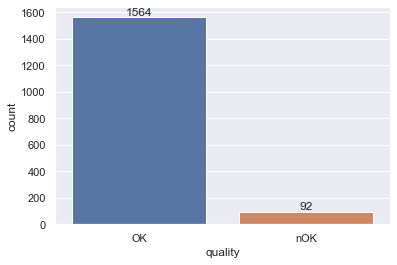

In [5]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(data=production_df, x='quality')
ax.bar_label(ax.containers[0])
plt.show()

### Statistics and distributions for sensor values

#### Calculation of Galton Skewness: return galton skewness and quantiles

In [21]:
def galton_skewness(a):
    quantiles = np.quantile(a,q=[0.25,0.5,0.75])
    skewness = (quantiles[0]+quantiles[2]-2*quantiles[2])/(quantiles[2]-quantiles[1])
    return (quantiles,skewness)

#### Insert empty columns 

In [22]:
production_df['s1_pmax'] = np.nan
production_df['s1_nmax'] = np.nan
production_df['s1_range'] = np.nan
production_df['s1_mean'] = np.nan
production_df['s1_mode'] = np.nan
production_df['s1_std'] = np.nan
production_df['s1_iqr'] = np.nan
production_df['s1_skew'] = np.nan
production_df['s1_kurtosis'] = np.nan
production_df['s1_q1'] = np.nan
production_df['s1_q2'] = np.nan
production_df['s1_q3'] = np.nan
production_df['s1_galton'] = np.nan
production_df['s2_pmax'] = np.nan
production_df['s2_nmax'] = np.nan
production_df['s2_range'] = np.nan
production_df['s2_mean'] = np.nan
production_df['s2_mode'] = np.nan
production_df['s2_std'] = np.nan
production_df['s2_iqr'] = np.nan
production_df['s2_skew'] = np.nan
production_df['s2_kurtosis'] = np.nan
production_df['s2_q1'] = np.nan
production_df['s2_q2'] = np.nan
production_df['s2_q3'] = np.nan
production_df['s2_galton'] = np.nan

#### Process all the time-series records for aggregation statistics

In [23]:
i =  0
for time in production_df['timestamp']:
    with open('./vibrationdata/'+time,'r') as vrb_file:
        s1 = []
        s2 = []
        for line in vrb_file:
            s1.append(float(line.split()[0])) #time series values for sensor 1
            s2.append(float(line.split()[1])) #time series values for sensor 2
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_pmax'] = max(s1) #positive maximum
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_nmax'] = min(s1) #negative maximum
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_range'] = max(s1) - min(s1) #range
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_mean'] = np.mean(s1) #average
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_mode'] = mode(s1)[0][0] #most frequent value
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_std'] = np.std(s1) #standard deviation
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_iqr'] = iqr(s1) #interquartile range
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_skew'] = skew(s1) #skewness
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_kurtosis'] = kurtosis(s1) #kurtosis
        gs = galton_skewness(s1) #calculation of galton skewness
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_q1'] = gs[0][0] #first quartile
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_q2'] = gs[0][1] #second quartile/median
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_q3'] = gs[0][2] #third quartile
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's1_galton'] = gs[1] #galton skewness
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_pmax'] = max(s2)
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_nmax'] = min(s2)
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_range'] = max(s2) - min(s2)
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_mean'] = np.mean(s2)
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_mode'] = mode(s2)[0][0]
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_std'] = np.std(s2) 
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_iqr'] = iqr(s2)
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_skew'] = skew(s2)
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_kurtosis'] = kurtosis(s2)
        gs = galton_skewness(s2)
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_q1'] = gs[0][0]
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_q2'] = gs[0][1]
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_q3'] = gs[0][2]
        production_df.at[production_df.loc[production_df['timestamp'] == time].index[0], 's2_galton'] = gs[1]
    i += 1
    print('Successfully processed '+str(i)+' data files')

Successfully processed 1 data files
Successfully processed 2 data files
Successfully processed 3 data files
Successfully processed 4 data files
Successfully processed 5 data files
Successfully processed 6 data files
Successfully processed 7 data files
Successfully processed 8 data files
Successfully processed 9 data files
Successfully processed 10 data files
Successfully processed 11 data files
Successfully processed 12 data files
Successfully processed 13 data files
Successfully processed 14 data files
Successfully processed 15 data files
Successfully processed 16 data files
Successfully processed 17 data files
Successfully processed 18 data files
Successfully processed 19 data files
Successfully processed 20 data files
Successfully processed 21 data files
Successfully processed 22 data files
Successfully processed 23 data files
Successfully processed 24 data files
Successfully processed 25 data files
Successfully processed 26 data files
Successfully processed 27 data files
Successful

Successfully processed 220 data files
Successfully processed 221 data files
Successfully processed 222 data files
Successfully processed 223 data files
Successfully processed 224 data files
Successfully processed 225 data files
Successfully processed 226 data files
Successfully processed 227 data files
Successfully processed 228 data files
Successfully processed 229 data files
Successfully processed 230 data files
Successfully processed 231 data files
Successfully processed 232 data files
Successfully processed 233 data files
Successfully processed 234 data files
Successfully processed 235 data files
Successfully processed 236 data files
Successfully processed 237 data files
Successfully processed 238 data files
Successfully processed 239 data files
Successfully processed 240 data files
Successfully processed 241 data files
Successfully processed 242 data files
Successfully processed 243 data files
Successfully processed 244 data files
Successfully processed 245 data files
Successfully

Successfully processed 438 data files
Successfully processed 439 data files
Successfully processed 440 data files
Successfully processed 441 data files
Successfully processed 442 data files
Successfully processed 443 data files
Successfully processed 444 data files
Successfully processed 445 data files
Successfully processed 446 data files
Successfully processed 447 data files
Successfully processed 448 data files
Successfully processed 449 data files
Successfully processed 450 data files
Successfully processed 451 data files
Successfully processed 452 data files
Successfully processed 453 data files
Successfully processed 454 data files
Successfully processed 455 data files
Successfully processed 456 data files
Successfully processed 457 data files
Successfully processed 458 data files
Successfully processed 459 data files
Successfully processed 460 data files
Successfully processed 461 data files
Successfully processed 462 data files
Successfully processed 463 data files
Successfully

Successfully processed 655 data files
Successfully processed 656 data files
Successfully processed 657 data files
Successfully processed 658 data files
Successfully processed 659 data files
Successfully processed 660 data files
Successfully processed 661 data files
Successfully processed 662 data files
Successfully processed 663 data files
Successfully processed 664 data files
Successfully processed 665 data files
Successfully processed 666 data files
Successfully processed 667 data files
Successfully processed 668 data files
Successfully processed 669 data files
Successfully processed 670 data files
Successfully processed 671 data files
Successfully processed 672 data files
Successfully processed 673 data files
Successfully processed 674 data files
Successfully processed 675 data files
Successfully processed 676 data files
Successfully processed 677 data files
Successfully processed 678 data files
Successfully processed 679 data files
Successfully processed 680 data files
Successfully

Successfully processed 873 data files
Successfully processed 874 data files
Successfully processed 875 data files
Successfully processed 876 data files
Successfully processed 877 data files
Successfully processed 878 data files
Successfully processed 879 data files
Successfully processed 880 data files
Successfully processed 881 data files
Successfully processed 882 data files
Successfully processed 883 data files
Successfully processed 884 data files
Successfully processed 885 data files
Successfully processed 886 data files
Successfully processed 887 data files
Successfully processed 888 data files
Successfully processed 889 data files
Successfully processed 890 data files
Successfully processed 891 data files
Successfully processed 892 data files
Successfully processed 893 data files
Successfully processed 894 data files
Successfully processed 895 data files
Successfully processed 896 data files
Successfully processed 897 data files
Successfully processed 898 data files
Successfully

Successfully processed 1089 data files
Successfully processed 1090 data files
Successfully processed 1091 data files
Successfully processed 1092 data files
Successfully processed 1093 data files
Successfully processed 1094 data files
Successfully processed 1095 data files
Successfully processed 1096 data files
Successfully processed 1097 data files
Successfully processed 1098 data files
Successfully processed 1099 data files
Successfully processed 1100 data files
Successfully processed 1101 data files
Successfully processed 1102 data files
Successfully processed 1103 data files
Successfully processed 1104 data files
Successfully processed 1105 data files
Successfully processed 1106 data files
Successfully processed 1107 data files
Successfully processed 1108 data files
Successfully processed 1109 data files
Successfully processed 1110 data files
Successfully processed 1111 data files
Successfully processed 1112 data files
Successfully processed 1113 data files
Successfully processed 11

Successfully processed 1302 data files
Successfully processed 1303 data files
Successfully processed 1304 data files
Successfully processed 1305 data files
Successfully processed 1306 data files
Successfully processed 1307 data files
Successfully processed 1308 data files
Successfully processed 1309 data files
Successfully processed 1310 data files
Successfully processed 1311 data files
Successfully processed 1312 data files
Successfully processed 1313 data files
Successfully processed 1314 data files
Successfully processed 1315 data files
Successfully processed 1316 data files
Successfully processed 1317 data files
Successfully processed 1318 data files
Successfully processed 1319 data files
Successfully processed 1320 data files
Successfully processed 1321 data files
Successfully processed 1322 data files
Successfully processed 1323 data files
Successfully processed 1324 data files
Successfully processed 1325 data files
Successfully processed 1326 data files
Successfully processed 13

Successfully processed 1515 data files
Successfully processed 1516 data files
Successfully processed 1517 data files
Successfully processed 1518 data files
Successfully processed 1519 data files
Successfully processed 1520 data files
Successfully processed 1521 data files
Successfully processed 1522 data files
Successfully processed 1523 data files
Successfully processed 1524 data files
Successfully processed 1525 data files
Successfully processed 1526 data files
Successfully processed 1527 data files
Successfully processed 1528 data files
Successfully processed 1529 data files
Successfully processed 1530 data files
Successfully processed 1531 data files
Successfully processed 1532 data files
Successfully processed 1533 data files
Successfully processed 1534 data files
Successfully processed 1535 data files
Successfully processed 1536 data files
Successfully processed 1537 data files
Successfully processed 1538 data files
Successfully processed 1539 data files
Successfully processed 15

#### View distribution of statistical features w.r.t quality

##### Scatter plot of max values of sensor 1 and sensor 2

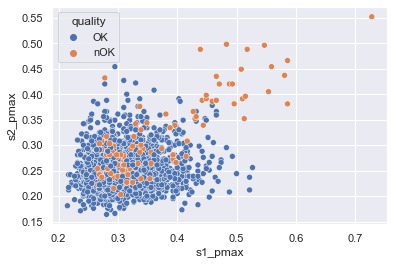

In [12]:
sns.scatterplot(x=production_df['s1_pmax'],y=production_df['s2_pmax'],hue=production_df['quality'])  
plt.show()

It can be seen that no apparent pattern exists that distinguishes maximum positive values from the two sensors, in terms of quality. 

##### Scatter plot of min values of sensor 1 and sensor 2

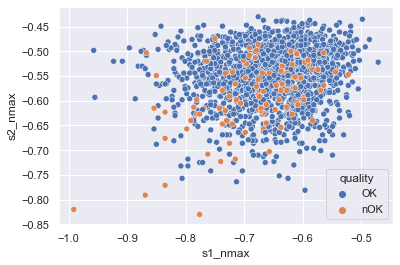

In [13]:
sns.scatterplot(x=production_df['s1_nmax'],y=production_df['s2_nmax'],hue=production_df['quality']) 
plt.show()

It can be seen that no apparent pattern exists that distinguishes maximum negative values from the two sensors, in terms of quality. 

##### Scatter plot of range of values of sensor 1 and sensor 2

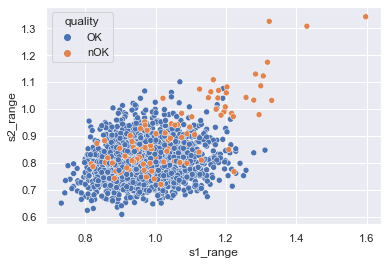

In [14]:
sns.scatterplot(x=production_df['s1_range'],y=production_df['s2_range'],hue=production_df['quality']) 
plt.show()

It can be seen that no apparent pattern exists that distinguishes range values from the two sensors, in terms of quality. 

##### Scatter plot of mean values of sensor 1 and sensor 2

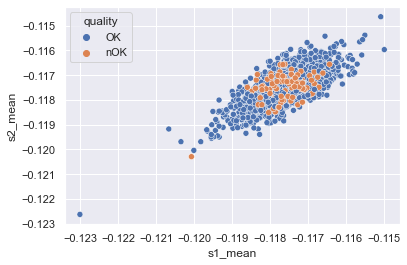

In [15]:
sns.scatterplot(x=production_df['s1_mean'],y=production_df['s2_mean'],hue=production_df['quality'])  
plt.show()

It can be seen that a pattern exists that distinguishes mean values from the two sensors, in terms of quality. Means of most nOK products is congregated, and surrounded by means of OK products. 

##### Scatter plot of mode values of sensor 1 and sensor 2

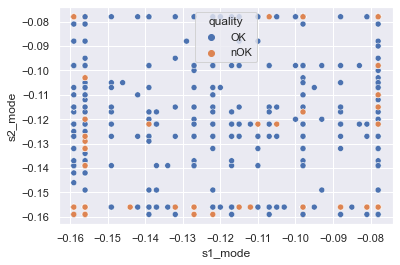

In [17]:
sns.scatterplot(x=production_df['s1_mode'],y=production_df['s2_mode'],hue=production_df['quality'])  
plt.show()

It can be seen that there exists no pattern that separates mode values from the two sensors, in terms of quality. 

##### Scatter plot of standard deviation of sensor 1 and sensor 2

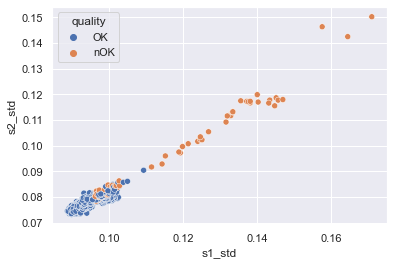

In [16]:
sns.scatterplot(x=production_df['s1_std'],y=production_df['s2_std'],hue=production_df['quality'])  
plt.show()

It can be seen that a linear separation line can be drawn that separates standard deviation values from the two sensors, in terms of quality. 

##### Scatter plot of IQR of sensor 1 and sensor 2

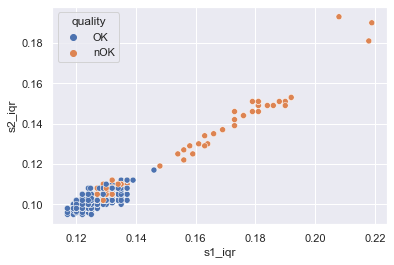

In [13]:
sns.scatterplot(x=production_df['s1_iqr'],y=production_df['s2_iqr'],hue=production_df['quality'])  
plt.show()

It can be seen that a linear separation line can be drawn that separates IQR values from the two sensors, in terms of quality. 

##### Scatter plot of skewness values of sensor 1 and sensor 2

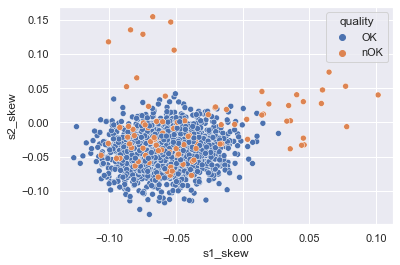

In [18]:
sns.scatterplot(x=production_df['s1_skew'],y=production_df['s2_skew'],hue=production_df['quality'])  
plt.show()

It can be seen that there exists no pattern that can distinguish between skewness values from the two sensors, in terms of quality. 

##### Scatter plot of kurtosis values of sensor 1 and sensor 2

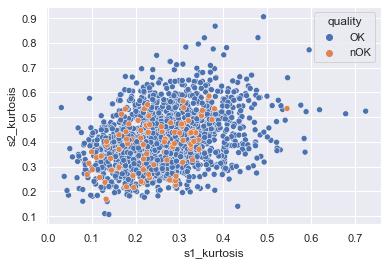

In [19]:
sns.scatterplot(x=production_df['s1_kurtosis'],y=production_df['s2_kurtosis'],hue=production_df['quality'])  
plt.show()

It can be seen that there exists no pattern that can distinguish between kurtosis values from the two sensors, in terms of quality. 

##### Scatter plot of first quartile values of sensor 1 and sensor 2

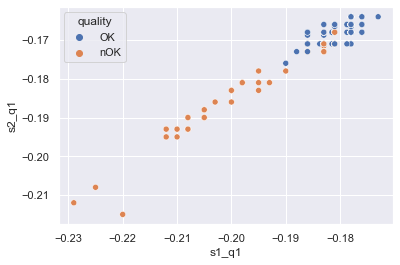

In [24]:
sns.scatterplot(x=production_df['s1_q1'],y=production_df['s2_q1'],hue=production_df['quality'])  
plt.show()

It can be seen that a linear separation line can be drawn that separates first quartile values from the two sensors, in terms of quality. 

##### Scatter plot of second quartile/median values of sensor 1 and sensor 2

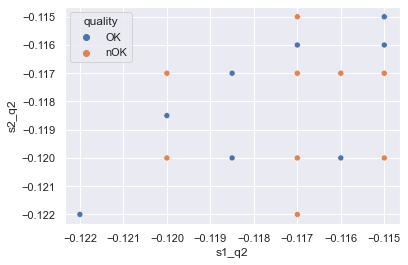

In [25]:
sns.scatterplot(x=production_df['s1_q2'],y=production_df['s2_q2'],hue=production_df['quality'])  
plt.show()

It can be seen that there exists no pattern that can distinguish between median values from the two sensors, in terms of quality. 

##### Scatter plot of third quartile values of sensor 1 and sensor 2

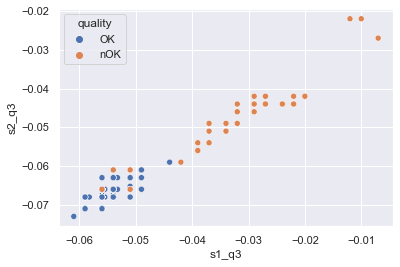

In [26]:
sns.scatterplot(x=production_df['s1_q3'],y=production_df['s2_q3'],hue=production_df['quality'])  
plt.show()

It can be seen that a linear separation line can be drawn that separates third quartile values from the two sensors, in terms of quality. This observation corresponds to IQR as IQR is defined as difference between third quartile and first quartile values. 

##### Scatter plot of Galton Skewness values of sensor 1 and sensor 2

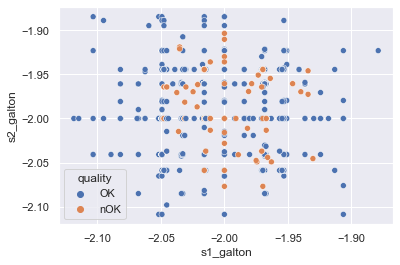

In [27]:
sns.scatterplot(x=production_df['s1_galton'],y=production_df['s2_galton'],hue=production_df['quality'])  
plt.show()

It can be seen that there exists no pattern that can distinguish between galton skewness values from the two sensors, in terms of quality.

#### Model Building

As the tree-based methods work well on unbalanced datasets, we are going to use XGBoost algorithm, gradient boosted ensemble of decision trees. 

##### Splitting training and testing data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(production_df[['s1_pmax','s2_pmax','s1_nmax','s2_nmax','s1_range','s2_range',
                                                                   's1_mean','s2_mean','s1_mode','s2_mode','s1_std','s2_std',
                                                                   's1_iqr','s2_iqr','s1_skew','s2_skew','s1_kurtosis','s2_kurtosis',
                                                                   's1_q1', 's2_q1','s1_q2', 's2_q2','s1_q3','s2_q3','s1_galton',
                                                                   's2_galton']], production_df['quality'], test_size=0.4, random_state=0)

##### Cross Validation

We take mean as chosen measure of central tendency and IQR as chosen measure of dispersion for our model building

In [31]:
clf = XGBClassifier(random_state=0,eval_metric="error")
scores = cross_val_score(clf, X_train[['s1_iqr','s2_iqr','s1_mean','s2_mean']], y_train, cv=10, scoring='f1_weighted')
print("10 Fold Cross-Validation on training data:")
print("%0.2f Weighted F1 Score with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

10 Fold Cross-Validation on training data:
0.96 Weighted F1 Score with a standard deviation of 0.02


##### Fitting the model and getting prediction

we noticed that using mean and IQR values of two sensors, our model can identify most nOK products. So , we use only those for model building. 

In [32]:
clf.fit(X_train[['s1_iqr','s2_iqr','s1_mean','s2_mean']],y_train)
y_pred = clf.predict(X_test[['s1_iqr','s2_iqr','s1_mean','s2_mean']])

##### Classification Metrics 

Accuracy, F1 Score and Matthews Correlation Coefficient are printed. Weighted average F1 Score is used to account for class imbalance. Matthews Correlation Coefficient can also handle large class imbalance. Also, classification report is printed to get an overview of key classification metrics for the two different classes. 

In [33]:
print("Accuracy: "+str(accuracy_score(y_test,y_pred)))
print("F1 Score: "+str(f1_score(y_test,y_pred,average='weighted')))
print("Matthews Correlation Coefficient:"+str(matthews_corrcoef(y_test,y_pred)))
print("Classification Report:\n"+classification_report(y_test, y_pred, target_names=['OK','nOK'], zero_division=0))

Accuracy: 0.9698340874811463
F1 Score: 0.9679833613251816
Matthews Correlation Coefficient:0.6680108029670354
Classification Report:
              precision    recall  f1-score   support

          OK       0.98      0.99      0.98       628
         nOK       0.78      0.60      0.68        35

    accuracy                           0.97       663
   macro avg       0.88      0.80      0.83       663
weighted avg       0.97      0.97      0.97       663



##### Confusion Matrix

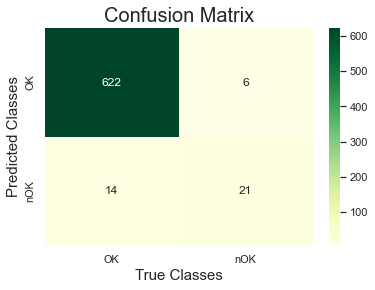

In [34]:
cm = confusion_matrix(y_test, y_pred, labels=["OK", "nOK"])
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="YlGn", xticklabels=['OK','nOK'], yticklabels=['OK','nOK']) 
plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('True Classes', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Predicted Classes', fontsize = 15) # y-axis label with fontsize 15
plt.show()

That's it. We can see that among 628 OK products, only 6 were classified incorrectly. Such misclassified products can be identified on a second manual inspection. However, among the 35 nOK products, only 14 were identified incorrectly, rest 21 products were properly identified. Thus our model was able to identify around 60% of the faulty products. 